In [ ]:
import zipfile

archive_path = '/content/archive.zip'  # Change to your file name
with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall('extracted_files/')  # Extract to a folder named 'extracted_files'


In [ ]:
import os

extracted_files = os.listdir('extracted_files/')
print(extracted_files)


['set_b', 'set_b.csv', 'set_a_timing.csv', 'set_a.csv', 'set_a']


In [ ]:
import os
import torch
import torchaudio
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import train_test_split

# Load audio file using torchaudio
def load_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    return waveform

# Extract MFCC features
def extract_mfcc(waveform, sr=16000, n_mfcc=13):
    mfcc = torchaudio.transforms.MFCC(
        sample_rate=sr,
        n_mfcc=n_mfcc,
        melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 23}
    )(waveform)
    return mfcc

MAX_MFCC_LENGTH = 100  # Reduced for computational efficiency

# Dataset class to handle heart sound data
class HeartSoundDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.audio_files = []
        self.label_mapping = {}
        self.current_label_id = 0

        for folder in ['set_a', 'set_b']:
            folder_path = os.path.join(self.root_dir, folder)
            if os.path.isdir(folder_path):
                for filename in os.listdir(folder_path):
                    if filename.endswith('.wav'):
                        file_path = os.path.join(folder_path, filename)
                        label = self._extract_label_from_filename(filename)
                        if label != 'nolbl':
                            if label not in self.label_mapping:
                                self.label_mapping[label] = self.current_label_id
                                self.current_label_id += 1
                            self.audio_files.append((file_path, self.label_mapping[label]))

        # Calculate class distribution
        self.class_counts = [0] * len(self.label_mapping)
        for _, label in self.audio_files:
            self.class_counts[label] += 1

    def _extract_label_from_filename(self, filename):
        label_part = filename.split('_')[0]
        if label_part == 'Aunlabelledtest' or label_part == 'Bunlabelledtest':
            label_part = 'nolbl'
        return label_part

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path, label = self.audio_files[idx]
        waveform = load_audio(audio_path)
        mfcc = extract_mfcc(waveform)

        mfcc = mfcc.squeeze(0)  # Remove unnecessary channel dimension
        if mfcc.shape[-1] < MAX_MFCC_LENGTH:
            pad_length = MAX_MFCC_LENGTH - mfcc.shape[-1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_length)), mode='constant')
        elif mfcc.shape[-1] > MAX_MFCC_LENGTH:
            mfcc = mfcc[:, :MAX_MFCC_LENGTH]

        mfcc = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0)  # Add channel dimension for CNN
        if self.transform:
            mfcc = self.transform(mfcc)
        return mfcc, label

# Load dataset
base_path = '/content/extracted_files'  # Set your dataset path here
dataset = HeartSoundDataset(root_dir=base_path)

# Train/test split
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

# Weighted random sampler for class balancing
train_class_counts = [0] * len(dataset.label_mapping)
for _, label in [dataset.audio_files[i] for i in train_indices]:
    train_class_counts[label] += 1

total_train_samples = len(train_subset)
class_weights = [total_train_samples / count if count > 0 else 0 for count in train_class_counts]
train_weights = [class_weights[label] for _, label in [dataset.audio_files[i] for i in train_indices]]

sampler = WeightedRandomSampler(train_weights, num_samples=total_train_samples, replacement=True)
train_loader = DataLoader(train_subset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# Define CNN-LSTM Model
class HeartSoundCNNLSTM(nn.Module):
    def __init__(self, num_classes=2):
        super(HeartSoundCNNLSTM, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(128 * 2, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = self.pool(F.relu(self.conv3(x)))

    # Get CNN output shape
      batch_size, channels, height, width = x.shape  # Example: (batch, 256, 4, 4)

    # Flatten height and width dimensions correctly
      x = x.view(batch_size, width, -1)  # (batch, time_steps, features)

    # Ensure LSTM gets correct input size
      x, _ = self.lstm(x)  # Pass through LSTM
      x = x[:, -1, :]  # Take the last LSTM output

    # Fully connected layer
      x = self.fc1(self.dropout(x))

      return x



# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(dataset.label_mapping)
model = HeartSoundCNNLSTM(num_classes=num_classes).to(device)

# Define loss function and optimizer
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the Model
num_epochs = 50
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved model with test accuracy: {best_accuracy:.2f}%")


<ipython-input-20-beae24e01b6d>:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0)  # Add channel dimension for CNN


Epoch [1/50]
Train Loss: 1.4101, Train Accuracy: 28.63%
Test Loss: 1.5105, Test Accuracy: 5.98%
Saved model with test accuracy: 5.98%
Epoch [2/50]
Train Loss: 1.2534, Train Accuracy: 28.63%
Test Loss: 1.4494, Test Accuracy: 8.55%
Saved model with test accuracy: 8.55%
Epoch [3/50]
Train Loss: 1.0297, Train Accuracy: 41.03%
Test Loss: 1.4122, Test Accuracy: 10.26%
Saved model with test accuracy: 10.26%
Epoch [4/50]
Train Loss: 0.9057, Train Accuracy: 42.31%
Test Loss: 1.4011, Test Accuracy: 11.11%
Saved model with test accuracy: 11.11%
Epoch [5/50]
Train Loss: 0.7896, Train Accuracy: 45.51%
Test Loss: 1.3946, Test Accuracy: 13.68%
Saved model with test accuracy: 13.68%
Epoch [6/50]
Train Loss: 0.6780, Train Accuracy: 52.56%
Test Loss: 1.3686, Test Accuracy: 13.68%
Epoch [7/50]
Train Loss: 0.5803, Train Accuracy: 52.99%
Test Loss: 1.2827, Test Accuracy: 16.24%
Saved model with test accuracy: 16.24%
Epoch [8/50]
Train Loss: 0.5696, Train Accuracy: 52.56%
Test Loss: 1.2509, Test Accuracy: 1

#T2



In [ ]:
import os
import torch
import torchaudio
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import train_test_split

# Load audio file using torchaudio
def load_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    return waveform

# Extract MFCC features
def extract_mfcc(waveform, sr=16000, n_mfcc=13):
    mfcc = torchaudio.transforms.MFCC(
        sample_rate=sr,
        n_mfcc=n_mfcc,
        melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 23}
    )(waveform)
    return mfcc

MAX_MFCC_LENGTH = 100  # Reduced for computational efficiency

# Dataset class to handle heart sound data
class HeartSoundDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.audio_files = []
        self.label_mapping = {}
        self.current_label_id = 0

        for folder in ['set_a', 'set_b']:
            folder_path = os.path.join(self.root_dir, folder)
            if os.path.isdir(folder_path):
                for filename in os.listdir(folder_path):
                    if filename.endswith('.wav'):
                        file_path = os.path.join(folder_path, filename)
                        label = self._extract_label_from_filename(filename)
                        if label != 'nolbl':
                            if label not in self.label_mapping:
                                self.label_mapping[label] = self.current_label_id
                                self.current_label_id += 1
                            self.audio_files.append((file_path, self.label_mapping[label]))

        # Calculate class distribution
        self.class_counts = [0] * len(self.label_mapping)
        for _, label in self.audio_files:
            self.class_counts[label] += 1

    def _extract_label_from_filename(self, filename):
        label_part = filename.split('_')[0]
        if label_part == 'Aunlabelledtest' or label_part == 'Bunlabelledtest':
            label_part = 'nolbl'
        return label_part

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path, label = self.audio_files[idx]
        waveform = load_audio(audio_path)
        mfcc = extract_mfcc(waveform)

        mfcc = mfcc.squeeze(0)  # Remove unnecessary channel dimension
        if mfcc.shape[-1] < MAX_MFCC_LENGTH:
            pad_length = MAX_MFCC_LENGTH - mfcc.shape[-1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_length)), mode='constant')
        elif mfcc.shape[-1] > MAX_MFCC_LENGTH:
            mfcc = mfcc[:, :MAX_MFCC_LENGTH]

        mfcc = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0)  # Add channel dimension for CNN
        if self.transform:
            mfcc = self.transform(mfcc)
        return mfcc, label

# Load dataset
base_path = '/content/extracted_files'  # Set your dataset path here
dataset = HeartSoundDataset(root_dir=base_path)

# Train/test split
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

# Weighted random sampler for class balancing
train_class_counts = [0] * len(dataset.label_mapping)
for _, label in [dataset.audio_files[i] for i in train_indices]:
    train_class_counts[label] += 1

total_train_samples = len(train_subset)
class_weights = [total_train_samples / count if count > 0 else 0 for count in train_class_counts]
train_weights = [class_weights[label] for _, label in [dataset.audio_files[i] for i in train_indices]]

sampler = WeightedRandomSampler(train_weights, num_samples=total_train_samples, replacement=True)
train_loader = DataLoader(train_subset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# Define CNN-LSTM Model
class HeartSoundCNNLSTM(nn.Module):
    def __init__(self, num_classes=2):
        super(HeartSoundCNNLSTM, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(128 * 2, num_classes)  # Adjusted for LSTM output
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Get CNN output shape
        batch_size, channels, height, width = x.shape  # Example: (batch, 256, 4, 4)

        # Flatten height and width dimensions correctly
        x = x.view(batch_size, width, -1)  # (batch, time_steps, features)

        # Ensure LSTM gets correct input size
        x, _ = self.lstm(x)  # Pass through LSTM
        x = x[:, -1, :]  # Take the last LSTM output

        # Fully connected layer
        x = self.fc1(self.dropout(x))

        return x

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(dataset.label_mapping)
model = HeartSoundCNNLSTM(num_classes=num_classes).to(device)

# Define loss function and optimizer
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the Model
num_epochs = 200
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved model with test accuracy: {best_accuracy:.2f}%")


<ipython-input-4-9ebd8ad30da7>:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0)  # Add channel dimension for CNN


Epoch [1/200]
Train Loss: 1.4201, Train Accuracy: 25.21%
Test Loss: 1.5048, Test Accuracy: 5.98%
Saved model with test accuracy: 5.98%
Epoch [2/200]
Train Loss: 1.1894, Train Accuracy: 39.32%
Test Loss: 1.4206, Test Accuracy: 10.26%
Saved model with test accuracy: 10.26%
Epoch [3/200]
Train Loss: 1.0450, Train Accuracy: 40.38%
Test Loss: 1.4016, Test Accuracy: 12.82%
Saved model with test accuracy: 12.82%
Epoch [4/200]
Train Loss: 0.9044, Train Accuracy: 45.30%
Test Loss: 1.3718, Test Accuracy: 13.68%
Saved model with test accuracy: 13.68%
Epoch [5/200]
Train Loss: 0.8082, Train Accuracy: 44.44%
Test Loss: 1.3429, Test Accuracy: 12.82%
Epoch [6/200]
Train Loss: 0.7049, Train Accuracy: 49.36%
Test Loss: 1.2803, Test Accuracy: 15.38%
Saved model with test accuracy: 15.38%
Epoch [7/200]
Train Loss: 0.6136, Train Accuracy: 54.91%
Test Loss: 1.2188, Test Accuracy: 16.24%
Saved model with test accuracy: 16.24%
Epoch [8/200]
Train Loss: 0.6180, Train Accuracy: 52.14%
Test Loss: 1.1898, Test A

<ipython-input-4-9ebd8ad30da7>:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0)  # Add channel dimension for CNN


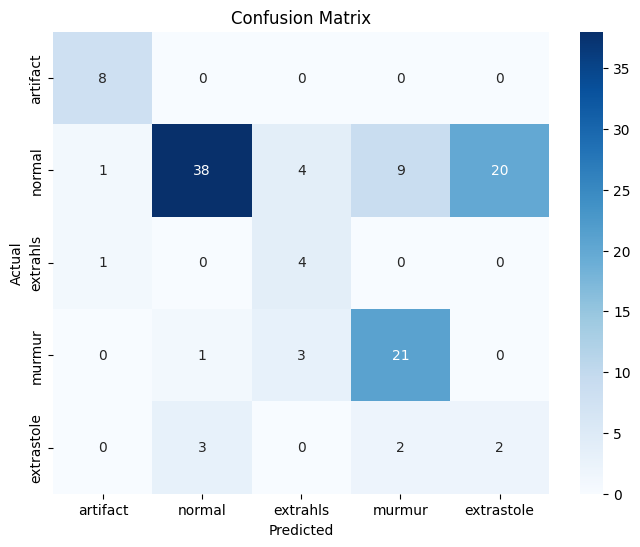

ValueError: multiclass format is not supported

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
import seaborn as sns

# Function to calculate evaluation metrics
def evaluate_model(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities for ROC curve
            _, predicted = torch.max(outputs, 1)  # Predicted labels

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(labels, probs):
    # Get the probabilities for the positive class
    fpr, tpr, _ = roc_curve(labels, probs[:, 1])  # Assuming binary classification
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Evaluation on the test set
labels, preds, probs = evaluate_model(model, test_loader, device)

# Confusion Matrix
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, list(dataset.label_mapping.keys()))

# ROC Curve
plot_roc_curve(labels, probs)

# F1 Score
f1 = f1_score(labels, preds, average='weighted')  # Use 'weighted' for multi-class classification
print(f"F1 Score: {f1:.4f}")


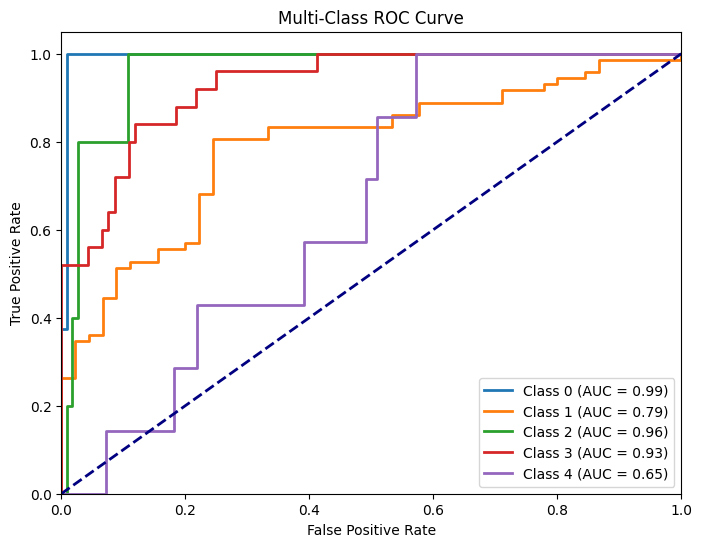

In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Function to plot multi-class ROC curve
def plot_multiclass_roc(labels, probs, n_classes):
    # One-hot encode labels
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))

    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = {}, {}, {}

    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Number of classes
n_classes = len(set(labels))  # Adjust based on your dataset

# Plot multi-class ROC
plot_multiclass_roc(labels, probs, n_classes)


In [7]:
from sklearn.metrics import f1_score
f1 = f1_score(labels, preds, average='weighted')
print(f"F1 Score: {f1:.4f}")


F1 Score: 0.6581


<ipython-input-4-9ebd8ad30da7>:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0)  # Add channel dimension for CNN


Class Distribution in Test Set: Counter({1: 72, 3: 25, 0: 8, 4: 7, 2: 5})


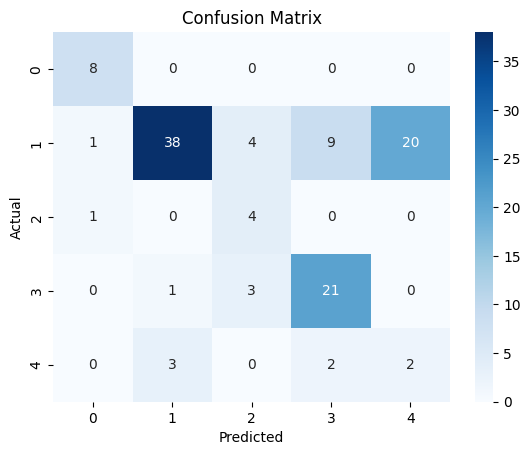

Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889         8
           1     0.9048    0.5278    0.6667        72
           2     0.3636    0.8000    0.5000         5
           3     0.6562    0.8400    0.7368        25
           4     0.0909    0.2857    0.1379         7

    accuracy                         0.6239       117
   macro avg     0.5631    0.6907    0.5861       117
weighted avg     0.7727    0.6239    0.6581       117

Overall ROC-AUC Score: 0.8657


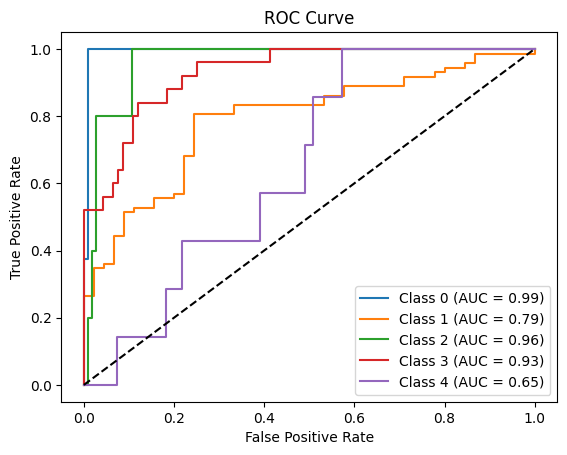

Hyperparameter tuning setup done! Modify StepLR or use GridSearch if needed.


In [8]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from collections import Counter

# Function to evaluate the model
def evaluate_model(model, dataloader, device, num_classes):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# Get predictions
labels, preds, probs = evaluate_model(model, test_loader, device, num_classes)

# 1️⃣ Check class distribution
print("Class Distribution in Test Set:", Counter(labels))

# 2️⃣ Confusion Matrix
conf_matrix = confusion_matrix(labels, preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 3️⃣ Precision, Recall, and F1-Score
print("Classification Report:")
print(classification_report(labels, preds, digits=4))

# 4️⃣ ROC Curve (One-vs-Rest for Multi-class)
if num_classes > 2:
    roc_auc = roc_auc_score(labels, probs, multi_class='ovr')
    print(f"Overall ROC-AUC Score: {roc_auc:.4f}")
    plt.figure()
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((labels == i).astype(int), probs[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
else:
    fpr, tpr, _ = roc_curve(labels, probs[:, 1])
    auc_score = auc(fpr, tpr)
    print(f"ROC-AUC Score: {auc_score:.4f}")
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# 5️⃣ Hyperparameter Tuning Placeholder (Adjust as needed)
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)  # Decay learning rate every 10 epochs
print("Hyperparameter tuning setup done! Modify StepLR or use GridSearch if needed.")
